# **Sumário**

<ol type="1">
  <li>Contexto;</li>
  <li>Pacotes e bibliotecas;</li>
  <li>Exploração e formatação;</li>
  <li>Formatação e limpeza de dados;</li>
  <li>Visualização;</li>
  <li>Machine Learning: Classificador</li>
  <li>Conclusão;</li>
</ol>


---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Temos um problema de distribuição e logística da distribuidora Loggi, parceira da EBAC no curso Análise de dados que forneceu os dados para estudarmos e fazermos a análise.

O Problema consiste em analisar e otimizar o processo de entrega. Existem HUBs de distribuição que tem um número de veículos que, no total, suportam uma carga X. Esse HUB recebe produtos e todos tem um trajeto entre o HUB -> ENTREGA FINAL... Precisamos encontrar sempre o HUB mais próximo da entrega e maximizar as entregas dentro da carga máxima de produtos que aquele HUB consegue entregar com seus veículos.

## 2\. Pacotes e bibliotecas

In [150]:
import json

import pandas as pd
import geopandas 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter 

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## 3\. Exploração de dados e formatação

Os dados disponibilizados pela Loggi estão no formato JSON e vamos entender eles ao inspecionar:

In [123]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
    data = json.load(file)

len(data)

199

Temos 199 instâncias dos dados e vamos entender a seguir o que isso significa:

In [124]:
json_format = json.dumps(data[0], indent=2)
print(json_format)

print('\n', data[0].keys())

{
  "name": "cvrp-2-df-33",
  "region": "df-2",
  "origin": {
    "lng": -48.05498915846707,
    "lat": -15.83814451122274
  },
  "vehicle_capacity": 180,
  "deliveries": [
    {
      "id": "313483a19d2f8d65cd5024c8d215cfbd",
      "point": {
        "lng": -48.11618888384239,
        "lat": -15.848929154862294
      },
      "size": 9
    },
    {
      "id": "320c94b17aa685c939b3f3244c3099de",
      "point": {
        "lng": -48.11819489551,
        "lat": -15.850772371049631
      },
      "size": 2
    },
    {
      "id": "3663b42f4b8decb33059febaba46d5c8",
      "point": {
        "lng": -48.11248339849675,
        "lat": -15.84787055941764
      },
      "size": 1
    },
    {
      "id": "e11ab58363c38d6abc90d5fba87b7d7",
      "point": {
        "lng": -48.11802268617869,
        "lat": -15.846471025281456
      },
      "size": 2
    },
    {
      "id": "54cb45b7bbbd4e34e7150900f92d7f4b",
      "point": {
        "lng": -48.114898174591026,
        "lat": -15.85805462185708

Podemos ver que nossos dados estão estruturados numa lista de dicionários e as chaves são as features de nossos dados, então, precisamos desaninhar toda essa informação futuramente

***CONTEXTUALIZANDO:*** a Loggi trabalha com HUBS de distribuição, cada instância dessa lista de dicionários é referente um conjunto de entregas de um HUB que precisa ser feito e cujas entregas estão definidas em 'deliveries'. Vamos, então, primeiramente avaliar nossas informações do HUB:

In [125]:
for key in data[0].keys():
    if key != 'deliveries':
        print(f'chave {key} com os valores \n {data[0][key]}')
        print()

chave name com os valores 
 cvrp-2-df-33

chave region com os valores 
 df-2

chave origin com os valores 
 {'lng': -48.05498915846707, 'lat': -15.83814451122274}

chave vehicle_capacity com os valores 
 180



Portanto, temos as informações: "nome da operação de entregas", região do HUB, (latitude,longitude) e a capacidade máxima de cargas que aquele HUB consegue distribuir de entregas 

E vamos ver as informações de entrega:

In [126]:
print(len(data[0]['deliveries']))
for delivery in data[0]['deliveries']:
    dicionario = delivery
    for key in dicionario.keys():
        print(f'chave {key} com os valores {dicionario[key]}\n')

4588
chave id com os valores 313483a19d2f8d65cd5024c8d215cfbd

chave point com os valores {'lng': -48.11618888384239, 'lat': -15.848929154862294}

chave size com os valores 9

chave id com os valores 320c94b17aa685c939b3f3244c3099de

chave point com os valores {'lng': -48.11819489551, 'lat': -15.850772371049631}

chave size com os valores 2

chave id com os valores 3663b42f4b8decb33059febaba46d5c8

chave point com os valores {'lng': -48.11248339849675, 'lat': -15.84787055941764}

chave size com os valores 1

chave id com os valores e11ab58363c38d6abc90d5fba87b7d7

chave point com os valores {'lng': -48.11802268617869, 'lat': -15.846471025281456}

chave size com os valores 2

chave id com os valores 54cb45b7bbbd4e34e7150900f92d7f4b

chave point com os valores {'lng': -48.114898174591026, 'lat': -15.85805462185708}

chave size com os valores 7

chave id com os valores 71271df40c3188cda88266f9969a5a9

chave point com os valores {'lng': -48.120447632397045, 'lat': -15.8477803198514}

chave

Então, para as entregas 'cvrp-2-df-33' (chave 'name' de data[0]) localizado no HUB df-2 temos 4588 entregas e, em cada uma delas, temos o id de entrega, o tamanho que a entrega irá ocupar no veículo e o local de entrega (latitude,longitude)

Precisamos levar a base para o Pandas para melhor análise:

In [127]:
deliveries_df = pd.DataFrame(data)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [128]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"]) #removendo a estrutura JSON na coluna origin para uma nova variável
display(hub_origin_df.head(), hub_origin_df.shape)

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


(199, 2)

Com o dados em mãos, vemos a proporcionalidade de 1 pra 1 tendo 199 instâncias e cada instância representa um HUB... Então, vamos simplesmente junta-los ao conjunto de dados principal:

In [129]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True) #juntando os dataframes alinhando por índice, pois tínhamos a proporção 1 pra 1

#agora, reajustando as colunas
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Agora, vamos regularizar o DataFrame para ***as entregas (deliveries)***

Repare que a coluna 'deliveries' é ainda pior, pois contém dados uma lista de dados aninhados das entregas como listas na estrutura do JSON. Então, vamos usar o comando explode para regularizar esses dados

In [130]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries") #transformando cada elemento da lista em uma linha
display(deliveries_exploded_df.head(), deliveries_exploded_df.shape, deliveries_exploded_df.index)

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


(636149, 1)

Index([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       ...
       198, 198, 198, 198, 198, 198, 198, 198, 198, 198],
      dtype='int64', length=636149)

Nesse momento, cada linha é um pedido para entrega e, em toda nossa base, temos 636,149 entregas!

Agora, temos um problema: perceba que o método 'explode' preserva o índice de cada elemento, então cada índice é respectivo à um conjunto de entregas, como podemos ver no `print(deliveries_exploded_df.index)` temos 199 índices no total distribuídos nas entregas, então perdemos aqui a proporcionalidade 1 pra 1 para juntar os dataframes, então vamos usar aqui outra estratégia para preservar os índices:

In [131]:
deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda tamanho_entrega: tamanho_entrega["size"])).rename(columns={"deliveries": "delivery_size"}),
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda longitude: longitude["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda latitude: latitude["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1) # aqui estamos montando um novo dataframe que é a junção dos 3 elementos, sendo adicionados "horizontalmente" (varrendo colunas)


display(deliveries_normalized_df.head())
display(len(deliveries_normalized_df))

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


636149

Com o dados explodidos, vamos normaliza-los para combina-los ao conjunto de dados principal:

In [132]:
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True) #método 'right' vai usar o index dos deliveries como referência
deliveries_df.reset_index(inplace=True, drop=True) #resetando index

display(deliveries_df.head())
display(deliveries_df.info())
display(deliveries_df.isna().any())

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


None

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

E vemos que o SCHEMA do projeto está ok para mais analises!

In [133]:
deliveries_df.select_dtypes("object").describe().T

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


Já conseguimos ver que o df-1 tem quase metade das entras, com 304,708 entregas passando por ele de todas as 636,149

## 4\. Manipulação e limpeza de dados

### 4\.1\. Geocodificação e enriquecimento

Obtendo Lat e Lon dos HUBS:

In [134]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Vamos usar agora o pacote Nominatim para nosso serviço de consulta

In [135]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 13551965,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.10000999999999993,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "stat

Vamos então aplicar a geocodificação nas coordenadas das três regiões dos HUBS e extrair informações de **cidade** e **bairro**.

E vamos fazer a requisição respeitando os intervalos de 1s exigidos na documentação

In [136]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


Aqui, já conseugimos ver o endereço de cada HUB

Agora, o professor do curso já disponibilizou o arquivo para análise das entregas:

In [137]:
deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
display(deliveries_geodata_df.head())
deliveries_geodata_df.info()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   delivery_lng     636149 non-null  float64
 1   delivery_lat     636149 non-null  float64
 2   delivery_city    634447 non-null  object 
 3   delivery_suburb  476264 non-null  object 
dtypes: float64(2), object(2)
memory usage: 19.4+ MB


Portanto, ao mesclarmos com nosso dataframe:

In [138]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
display(deliveries_df.head())
deliveries_df.info()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
 8   delivery_city     634447 non-null  object 
 9   delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 48.5+ MB


Como temos um valor elevado de dados faltantes no Suburb, iremos analisar somente a city como dado geográfico:

In [139]:
deliveries_df = deliveries_df.drop('delivery_suburb', axis=1)

display(deliveries_df.head())
deliveries_df.info()
print()
print(f'{100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))}%')

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929,Ceilândia
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772,Ceilândia
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871,Ceilândia
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471,Ceilândia
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
 8   delivery_city     634447 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 43.7+ MB

0.26754738276724477%


Agora, nosso Schema é bem satisfatório apesar de poucos dados faltantes em `delivery_city` (menos de 1% dos dados faltantes)

## 5\. Visualização

In [140]:
mapa = geopandas.read_file("lml_unidade_federacao_a.shp")
mapa = mapa.loc[[1]]
mapa.head()

,geometry
1,"POLYGON ((-47.30850 -16.04997, -47.30997 -16.0..."


No snippet de código acima importamos o formato de Brasília (arquivo .shp) através do site do IBGE e, agora, iremos transformar lat e lng em pontos geopandas

E agora, precisamos transformar os nossos dataframes em geodataframes usando geopandas:

In [141]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
display(geo_hub_df.head())


geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
display(geo_deliveries_df.head())

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929,Ceilândia,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772,Ceilândia,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871,Ceilândia,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471,Ceilândia,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


portanto, podemos plottar usando a feature `geometry` e a biblioteca Matplotlib

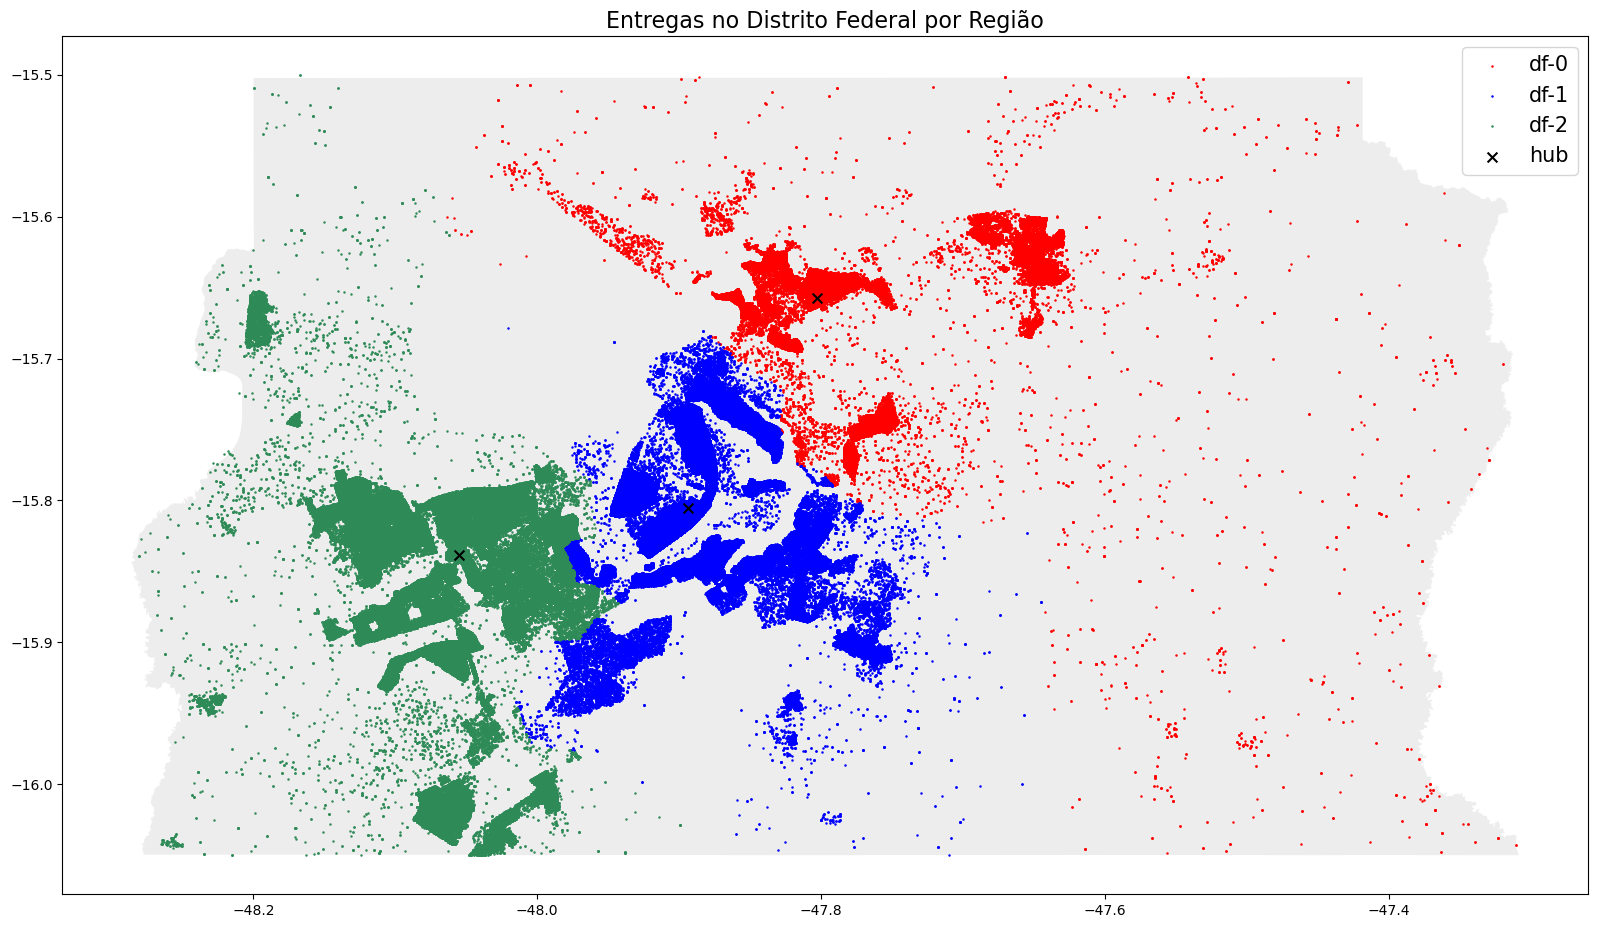

In [142]:

# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=0.6, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=0.6, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=0.6, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=50, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15}, loc='upper right')


In [143]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


/Users/antoniopilan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/antoniopilan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/antoniopilan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


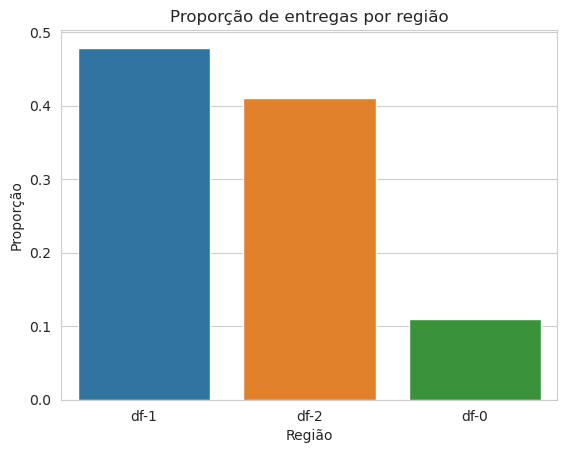

In [144]:
with sns.axes_style('whitegrid'):
    grafico = sns.barplot(data=data, x="region", y="proportion", errorbar=None)
    grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção')

E, quando vemos quantas entregas temos por região, conseguimos ver que a região central de Brasília tem a maior parte das entregas enquanto a região df-0 tem menor volume de entregas, porém, ao olhar a distribuição dos pontos, podemos ver que está se tratando da região rural de Brasília, aonde os pontos são mais espalhados e as distâncias de entrega maiores.

/Users/antoniopilan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/antoniopilan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/antoniopilan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/antoniopilan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

[[]]

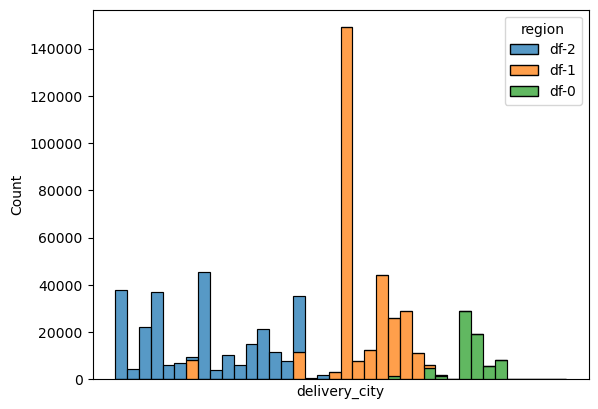

In [145]:
g= sns.histplot(data=geo_deliveries_df, x='delivery_city', hue = 'region', multiple='stack')
g.set(xticks = [])

E quando vemos as entregas a partir de city vemos uma confirmação do acontecimento, temos menos entregas na região df-0, uma cidade em destaque no centro populacional df-1 e uma distribuição mais uniforme em df-2

Agora, vamos criar um modelo de Machine Learning aonde, a partir de coordenadas Lat e Lon de uma entrega, ele vai nos retornar qual HUB vai fazer essa entrega:

## 6. Machine Learning: Classificador


In [ ]:
deliveries_ml_data = geo_deliveries_df.drop(['name', 'delivery_size',
                                            'vehicle_capacity', 
                                            'geometry', 'delivery_city',
                                            'hub_lng', 'hub_lat'], axis = 1)


display(deliveries_ml_data)

,region,delivery_lng,delivery_lat
0,df-2,-48.116189,-15.848929
1,df-2,-48.118195,-15.850772
2,df-2,-48.112483,-15.847871
3,df-2,-48.118023,-15.846471
4,df-2,-48.114898,-15.858055
...,...,...,...
636144,df-2,-48.064269,-15.997694
636145,df-2,-48.065176,-16.003597
636146,df-2,-48.065841,-16.003808
636147,df-2,-48.062327,-16.001568


Como queremos fazer uma previsão de uma variável categórica, vamos usar modelos classificadores, no caso, vamos comparar Random Forest e KNN

In [ ]:
#arvore de decisao
from sklearn.ensemble import RandomForestClassifier
#knn
from sklearn.neighbors import KNeighborsClassifier

modelo_randomforest = RandomForestClassifier() #modelo criado
modelo_knn = KNeighborsClassifier() #modelo criado

Com os modelos criados, vamos separar nosso df entre teste e treino:

In [155]:
y = deliveries_ml_data['region']
x = deliveries_ml_data.drop(['region'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x,y, random_state=0)

print("X_train shape: {}".format(X_train.shape)) 
print("y_train shape: {}".format(y_train.shape))

print("X_test shape: {}".format(X_test.shape)) 
print("y_test shape: {}".format(y_test.shape))

X_train shape: (477111, 2)
y_train shape: (477111,)
X_test shape: (159038, 2)
y_test shape: (159038,)


E, por fim, executar o modelo de ML:

In [154]:
modelo_randomforest.fit(X_train,y_train)
modelo_knn.fit(X_train,y_train)

previsao_randomforest = modelo_randomforest.predict(X_test)
previsao_knn = modelo_knn.predict(X_test)

print(accuracy_score(y_test, previsao_randomforest))
print(accuracy_score(y_test, previsao_knn))

0.9998490926696765
0.9995472780090293


O modelo, somente usando lat e lon, conseguiu obter aproximadamente 99,9% de precisão no modelo

Mas só isso não é suficiente, precisamos realmente validar o sistema então vamos montar um projeto de CV (Cross Validation)

In [169]:
scores = cross_val_score(modelo_knn, x, y, cv=10, scoring='accuracy')

print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.99970 (+/- 0.00012)


Vemos que é quase unânime o acerto do modelo para definir qual HUB vai fazer a distribuição das entregas

## 7. Conclusão


Conseguimos ver que cada HUB (df-`x`) é responsável por uma área do Distrido Federal:

- df-1: uma região concentrada + regiões rurais
- df-2: região centrao do DF, incluindo Brasília, por isso a maior parte das entregas se concentra aqui
- df-3: focada para região urbanda do DF

E qual HUB faz a entrega é definido pela posição ou região em que aquele HUB cobre.


Também podemos confirmar que o HUB da entrega é definido somente pela posição geográfica devido a altíssima precisão do modelo.

E, por fim, podemos usar esse modelo dinamicamente como backend numa aplicação para inserirmos localização lat/lon e definir qual HUB fará a entrega no Distrito Federal